In [127]:
##### Imports ##### 

# Data viz and manipulation
import pandas as pd , numpy as np 
import matplotlib.pyplot as plt , seaborn as sns

# Modeling 
from sklearn.linear_model import LinearRegression , ElasticNet , Lasso , Ridge 
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor 
from mlxtend.regressor import StackingRegressor
from xgboost import XGBRegressor 
from catboost import CatBoostRegressor
from sklearn.svm import SVR

# Preprocessing and model selection
from BestSetUp import BestSetUp # My custom class
from sklearn.model_selection import cross_val_score , train_test_split , GridSearchCV
from sklearn.metrics import make_scorer , mean_absolute_percentage_error , r2_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler , RobustScaler , QuantileTransformer
import optuna


# Warning and seed
np.random.seed(1234)
import warnings
warnings.filterwarnings('ignore')

In [2]:
##### Constants #####

df = pd.read_csv('get_around_pricing_project.csv' , index_col='Unnamed: 0')
list_scalers = [RobustScaler() , MinMaxScaler() , StandardScaler()  , QuantileTransformer()]
list_models = [Lasso() ,  Ridge() , LinearRegression() , ElasticNet()  , XGBRegressor()
                , SVR() , RandomForestRegressor() , AdaBoostRegressor() , CatBoostRegressor(verbose=0),
                StackingRegressor(regressors=[ElasticNet() , Lasso() , Ridge()] , meta_regressor=LinearRegression())]


# Target encoding values. Mandatory for the pipeline
target_encoding_values = {}
for col in df.select_dtypes(include=object):
    mean_values = dict(df.groupby(col)['rental_price_per_day'].mean())
    target_encoding_values[col] = mean_values


df.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [3]:
# Find the optimal set up
best_set_up_model = BestSetUp(X=df.drop('rental_price_per_day' , axis=1) , y=df[['rental_price_per_day']],
                        models=list_models , scalers=list_scalers,
                        n_cv=10 , multiclass=False)

best_set_up_string = best_set_up_model.get_best_setup()

Choosing model ...


100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


Choosing scaler ...


100%|██████████| 4/4 [00:46<00:00, 11.50s/it]


Choosing categorical preprocessing ...
Dealing with outliers ...



In [153]:
X , y = best_set_up_model.get_X_and_y()
print(best_set_up_string)

Best model : <catboost.core.CatBoostRegressor object at 0x0000023CFDB22CB0>
Best scaler : QuantileTransformer()
Best categorical processing : Target encoding        
With or without outliers : Better get rid of the most extreme 5 percent


In [23]:
model = CatBoostRegressor(verbose=0)
scores_rmse = cross_val_score(estimator=model , X=X , y=y ,n_jobs=-1 , cv=50 , scoring='neg_root_mean_squared_error')
print('Cross val score RMSE mean : ' , round(-np.mean(scores_rmse) , 2))
print('Cross val score RMSE standard deviation : ' , round(np.std(scores_rmse),2))

scores_mape = cross_val_score(estimator=model , X=X , y=y ,n_jobs=-1 , cv=50 , scoring=make_scorer(mean_absolute_percentage_error))
print('Cross val score MAPE mean : ' , round(np.mean(scores_mape) , 2) , ' %')
print('Cross val score MAPE standard deviation : ' , round(np.std(scores_mape),2))

Cross val score RMSE mean :  14.5
Cross val score RMSE standard deviation :  4.29
Cross val score MAPE mean :  0.12  %
Cross val score MAPE standard deviation :  0.06


In [30]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.0001, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.0001, 10.0),
        'random_strength': trial.suggest_loguniform('random_strength', 0.0001, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 10_000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1),
        'od_type': "Iter",
        'od_wait': 10
    }
    
    model = CatBoostRegressor(**params , verbose=0)
    rmse_scores = -cross_val_score(model, X, y, cv=10, scoring='neg_root_mean_squared_error' , n_jobs=-1)
    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(study.best_params)

[I 2023-04-14 20:08:24,293] A new study created in memory with name: no-name-60a30028-766a-4690-a72f-1a4493d4900b
[I 2023-04-14 20:08:26,172] Trial 0 finished with value: 15.349313349700783 and parameters: {'learning_rate': 0.03170657994058916, 'depth': 5, 'l2_leaf_reg': 3.7387704758266107, 'bagging_temperature': 3.7359151308508265, 'random_strength': 0.12821726557642085, 'n_estimators': 978, 'subsample': 0.8754000727621127, 'colsample_bylevel': 0.5677881119024052}. Best is trial 0 with value: 15.349313349700783.
[I 2023-04-14 20:08:38,797] Trial 1 finished with value: 24.23935436363946 and parameters: {'learning_rate': 0.00010621391058364352, 'depth': 6, 'l2_leaf_reg': 0.0017435869779370377, 'bagging_temperature': 0.10069342589299618, 'random_strength': 0.00085402273834306, 'n_estimators': 4751, 'subsample': 0.5737871709730147, 'colsample_bylevel': 0.9795088623475197}. Best is trial 0 with value: 15.349313349700783.
[I 2023-04-14 20:08:53,412] Trial 2 finished with value: 15.489528190

{'learning_rate': 0.005341480462907889, 'depth': 6, 'l2_leaf_reg': 0.9889876054707877, 'bagging_temperature': 0.6710010854255729, 'random_strength': 0.0008531278555419199, 'n_estimators': 8246, 'subsample': 0.8666800354980602, 'colsample_bylevel': 0.7272033938288825}


In [31]:
'''best_params = {'learning_rate': 0.005341480462907889, 'depth': 6, 'l2_leaf_reg': 0.9889876054707877, 'bagging_temperature': 0.6710010854255729, 'random_strength': 0.0008531278555419199, 'n_estimators': 8246, 'subsample': 0.8666800354980602, 'colsample_bylevel': 0.7272033938288825}'''
model = CatBoostRegressor(**study.best_params , verbose=0)
scores_rmse = cross_val_score(estimator=model , X=X , y=y ,n_jobs=-1 , cv=50 , scoring='neg_root_mean_squared_error')
print('Cross val score RMSE mean : ' , round(-np.mean(scores_rmse) , 2))
print('Cross val score RMSE standard deviation : ' , round(np.std(scores_rmse),2))

scores_mape = cross_val_score(estimator=model , X=X , y=y ,n_jobs=-1 , cv=50 , scoring=make_scorer(mean_absolute_percentage_error))
print('Cross val score MAPE mean : ' , round(np.mean(scores_mape) , 2) , ' %')
print('Cross val score MAPE standard deviation : ' , round(np.std(scores_mape),2))

Cross val score RMSE mean :  14.48
Cross val score RMSE standard deviation :  4.31
Cross val score MAPE mean :  0.12  %
Cross val score MAPE standard deviation :  0.06


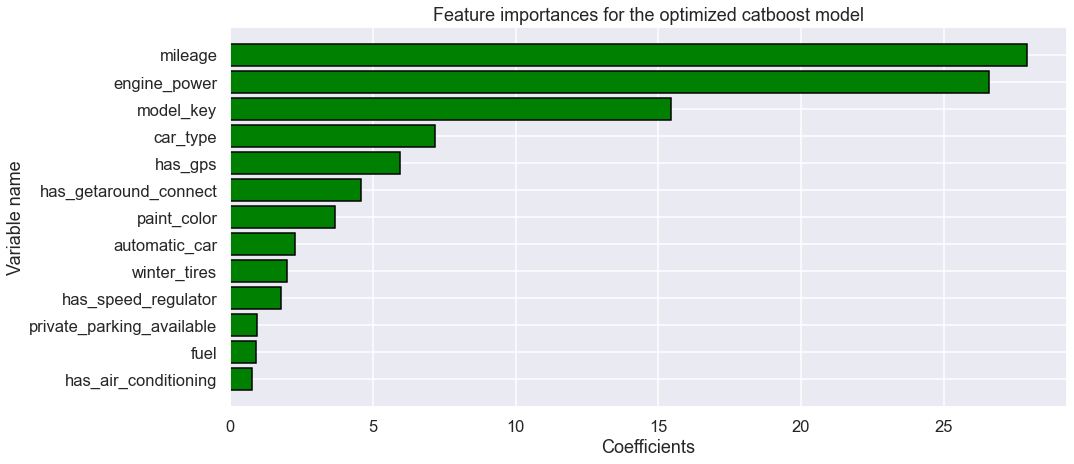

In [154]:
model.fit(X , y)
to_plot = dict(zip(model.feature_names_ , model.feature_importances_ ))
to_plot_df = pd.DataFrame({'Feature' : to_plot.keys() , 'Coefficient' : to_plot.values()})
to_plot_df['Abs coeff'] = abs(to_plot_df['Coefficient'])
to_plot_df = to_plot_df.sort_values(by='Abs coeff' , ascending=True).drop('Abs coeff' , axis=1 , errors='ignore')
to_plot_df['colors'] = ['green' if coef >= 0 else 'red' for coef in to_plot_df['Coefficient']]

with sns.plotting_context('talk'):
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,7))
    plt.barh(to_plot_df['Feature'] , to_plot_df['Coefficient'] , color=to_plot_df['colors'] , edgecolor='black')
    plt.title('Feature importances for the optimized catboost model')
    plt.xlabel('Coefficients')
    plt.ylabel('Variable name')
    plt.show()

In [155]:
def pipeline(to_predict : pd.DataFrame , model=model , target_encoding_values=target_encoding_values):

    # Deal with numerical values
    for col in to_predict.select_dtypes(include=np.number):
        to_predict[col] = QuantileTransformer().fit_transform(to_predict[col].values.reshape(-1 , 1))
    
    # Deal with categorical columns
    for col in to_predict.select_dtypes(include=object):
        means_values = target_encoding_values.get(col)
        to_predict[col] = [means_values.get(val) for val in list(to_predict[col])]
        to_predict[col] = QuantileTransformer().fit_transform(to_predict[col].values.reshape(-1,1))

    return list(model.predict(to_predict))